In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
from my_modules import compute

In [3]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import seaborn as sns

sns.set_style("whitegrid")

font = {'family': 'sans-serif', 'serif' : 'Helvetica',
        'size'   : 25}
plt.rc('font', **font)

In [4]:
# color map
ce_cmap = sns.diverging_palette(20, 220, as_cmap=True)
interaction_cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
plasticity_cmap = 'RdGy'

In [5]:
storage = os.environ['MICOM_EXP'] + 'setA_coculture_b12_c96/' # on Peregrine
print(storage)

meta_species = pd.read_csv(storage + "selected_species_setA.tsv", sep="\t")
meta_species

/data/s4278836/First_project/experiments/setA_coculture_b12_c96/


Ecotype Ecotype_ID Species_ID                             Species_name
0       I        I_a    setA_15                Helicobacter_pylori_26695
1       I        I_b    setA_21           Pseudomonas_nitroreducens_HBP1
2      II       II_a    setA_11               Eggerthella_lenta_DSM_2243
3      II       II_b    setA_24         Ruminococcus_lactaris_ATCC_29176
4     III      III_a     setA_6         Brevibacillus_brevis_NBRC_100599
5     III      III_b    setA_13  Escherichia_coli_str_K_12_substr_MG1655
6      IV       IV_a    setA_19             Odoribacter_laneus_YIT_12061
7      IV       IV_b    setA_20           Peptoniphilus_timonensis_JC401
8       V        V_a    setA_16              Lactobacillus_gastricus_PS3

In [6]:
data_dir = storage + 'features/'

media=['EU_avg', 'high_fat']

# for computing interaction coefficients
mono_data_dir = os.environ['MICOM_EXP'] + 'setA_mono_b12_c144/features/' # on Peregrine

In [7]:
culture_type = 'continuous'

# for competitive exclusion assessment
min_density=1.0e-2

In [8]:
# for annotating species with their "degree of plasticity" in mono-culture
mono_plasticity_file = "../setA_mono_b12_c144/features/log_fold_change.plasticity.tsv"

mono_plasticity = pd.read_csv(mono_plasticity_file, sep='\t', usecols=['species_ID', 'media', 'log_fold_change', 'culture_type'])

# to extract list of species ID in the correct order
plastic_interactions, plastic_meta = compute.interaction_coeffs(data_dir, mono_data_dir, culture_type, media, plastic=True, 
                                                                rm_compet_excl=True, min_survived=min_density,
                                                                intra=True, method='glv')

mono_plas = mono_plasticity.loc[(mono_plasticity['culture_type'] == culture_type) & (mono_plasticity['media'].isin(media)) &
                                (mono_plasticity['species_ID'].isin(plastic_meta['species_ID'])), :]

mono_plas = mono_plas.pivot(index='species_ID', columns='media', values='log_fold_change')
mono_plas = mono_plas.reindex(index=plastic_meta['species_ID'])
mono_plas = mono_plas.reindex(columns=media)

pmo_min = mono_plasticity['log_fold_change'].min() # min across all 18 species of set A & all 11 diets - to get negative value
print(pmo_min)
pmo_max = mono_plas.to_numpy().max()
print(pmo_max)

mono_plas

-0.009463740740957792
4.478131823042856


/data/s4278836/First_project/analysis/setA_coculture_b12_c96/my_modules/compute.py:67: RuntimeWarning: Mean of empty slice
  data_mat[i, :, :] = np.nanmean(layer, axis=0) # averaging across replicates for each medium


media         EU_avg      high_fat
species_ID                        
setA_15     4.478132  1.337440e+00
setA_21     0.618262  2.446184e+00
setA_11     1.744466  3.203427e-16
setA_24     0.000000  1.472066e+00
setA_16     0.000011  1.018946e-04

# $ P_{co} = log_{2}(\frac {\rho_{ON}} {\rho_{OFF}}) $

In [9]:
plastic_stack_meta, meta = compute.stack_co_media(data_dir, culture_type, media, plastic=True, 
                                                  rm_compet_excl=False,#True, ce_feature='od', min_survived=min_density, 
                                                  method='mean')

sfm_stack_meta, meta = compute.stack_co_media(data_dir, culture_type, media, plastic=False, 
                                              rm_compet_excl=False,#True, ce_feature='od', min_survived=min_density, 
                                              method='mean')

/data/s4278836/First_project/analysis/setA_coculture_b12_c96/my_modules/compute.py:67: RuntimeWarning: Mean of empty slice
  data_mat[i, :, :] = np.nanmean(layer, axis=0) # averaging across replicates for each medium


In [10]:
compet_excl = np.isnan(plastic_stack_meta) | np.isnan(sfm_stack_meta)

ratio = np.full(plastic_stack_meta.shape, np.nan)
np.divide(plastic_stack_meta, sfm_stack_meta, out=ratio, where=~compet_excl)

lfc = np.full(plastic_stack_meta.shape, np.nan)
np.log2(ratio, out=lfc, where=~np.isnan(ratio))

lfc

array([[[            nan,  6.49426162e+00,  6.53719262e+00,
          4.51207893e+00,  4.55328755e+00],
        [ 5.01030479e-01,             nan,  6.26022021e-01,
          6.18265075e-01,  6.19321192e-01],
        [ 1.74412910e+00,  2.87664486e+00,             nan,
          1.74450088e+00,  1.76114083e+00],
        [ 6.51763608e-06,  0.00000000e+00, -1.80320280e+01,
                     nan, -1.50645867e-02],
        [-4.72748869e+00, -1.18951252e+01, -8.16273306e+00,
          1.38706673e-05,             nan]],

       [[            nan,  1.28465940e+00,  1.39429942e+00,
          1.39852275e+00,  1.39433410e+00],
        [ 2.26251384e+00,             nan,  2.27219380e+00,
          2.44618414e+00,  2.44618554e+00],
        [ 3.20342650e-16, -5.76923401e-06,             nan,
         -5.77326208e-04,  3.20342650e-16],
        [ 2.48136378e+00,  1.47199903e+00,  1.45114655e+00,
                     nan,  1.45855576e+00],
        [ 4.74456745e-04, -1.82931789e+01,  3.57730785e-04,
  

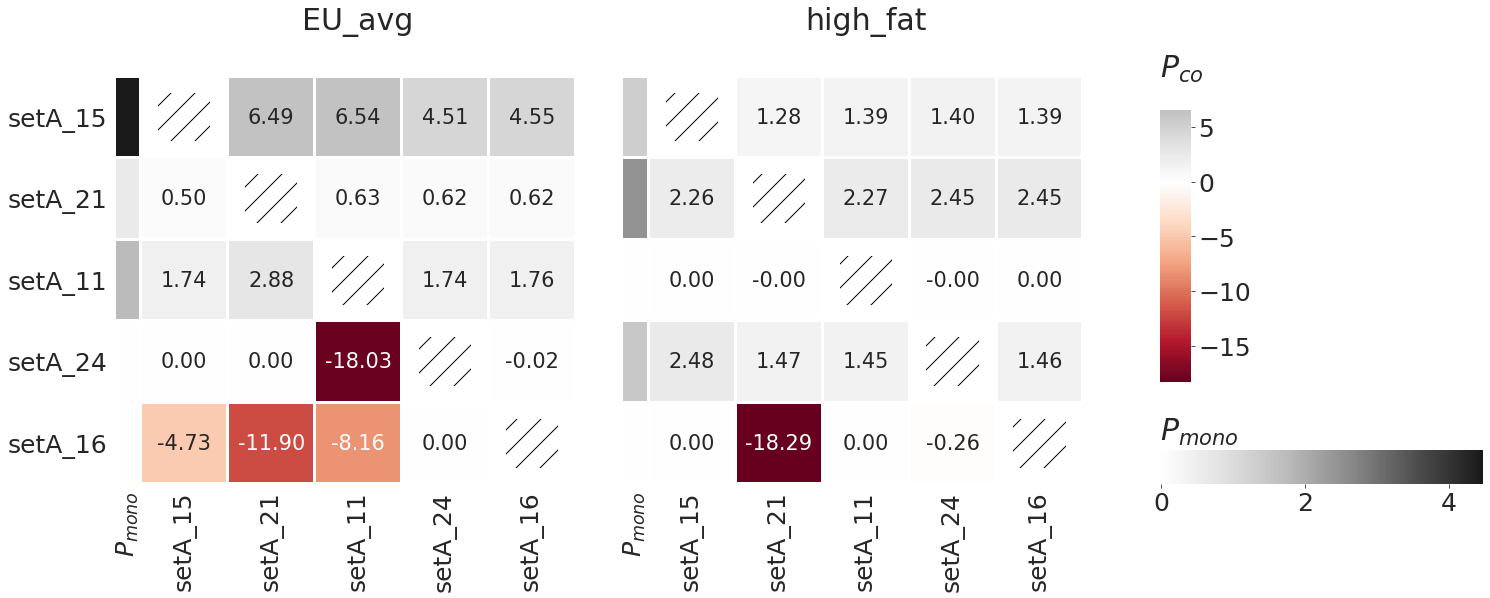

In [11]:
fig = plt.figure(figsize=(24.54, 7.5))


outer = gridspec.GridSpec(nrows=12, ncols=2, figure=fig, wspace=0.12, hspace=0.0, width_ratios=[0.75, 0.25])

inner_heatmap = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=outer[:, 0], 
                                                 wspace=0.1, hspace=0.0, width_ratios=[0.5, 0.5])
inner_cbar = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=10, subplot_spec=outer[1:-3, 1], wspace=0.05, hspace=0.0)

eu_space = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=inner_heatmap[0], 
                                             wspace=0.0, hspace=0.0, width_ratios=[0.058, 0.942])

fat_space = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=inner_heatmap[1], 
                                             wspace=0.0, hspace=0.0, width_ratios=[0.058, 0.942])

eu_meta = fig.add_subplot(eu_space[0])
eu_hm = fig.add_subplot(eu_space[1])
eu_hm.set_title('EU_avg', y=1.1)

fat_meta = fig.add_subplot(fat_space[0])
fat_hm = fig.add_subplot(fat_space[1])
fat_hm.set_title('high_fat', y=1.1)

cbar_ax = fig.add_subplot(inner_cbar[0])
cbar_ax.set_title(r'$\it{P}_{co}$', fontdict={'fontsize':30}, loc='left', y=1.1)

meta_cbar = fig.add_subplot(outer[-1,-1])
meta_cbar.set_title(r'$\it{P}_{mono}$', fontdict={'fontsize':30}, loc='left', y=1.1)

pmin = np.nanmin(lfc)
pmax = np.nanmax(lfc)

# P_co
sns.heatmap(data=lfc[0, :,:],
            xticklabels=meta['species_ID'], yticklabels=False, 
            cmap=plasticity_cmap, vmin=pmin, vmax=pmax, center=0.0, square=True, linewidths=2.0, 
            annot=True, fmt='.2f', annot_kws={'fontsize':'small'},
            cbar=False, ax=eu_hm)

sns.heatmap(data=lfc[1, :,:],
            xticklabels=meta['species_ID'], yticklabels=False, 
            cmap=plasticity_cmap, vmin=pmin, vmax=pmax, center=0.0, square=True, linewidths=2.0, 
            annot=True, fmt='.2f', annot_kws={'fontsize':'small'},
            cbar_ax=cbar_ax, ax=fat_hm)

# Annotate region of intra-species interaction 
eu_patch = [(a+0.2, a+0.2) for a in range(lfc[0,:,:].shape[1])]
for p in eu_patch:
    eu_hm.add_patch(Rectangle(p, 0.6, 0.6, hatch='/', edgecolor='black', fill=False, lw=0))

fat_patch = [(a+0.2, a+0.2) for a in range(lfc[1,:,:].shape[1])]
for p in fat_patch:
    fat_hm.add_patch(Rectangle(p, 0.6, 0.6, hatch='/', edgecolor='black', fill=False, lw=0))

# Species metadata
eu_meta = sns.heatmap(mono_plas[[media[0]]],xticklabels=[r'$\it{P}_{mono}$'], yticklabels=True, 
                           cmap=plasticity_cmap, center=0.0, vmin=pmo_min, vmax=pmo_max, linewidths=2.0, 
                           cbar_ax=meta_cbar, cbar_kws={"orientation": "horizontal"}, ax=eu_meta)
eu_meta.set_ylabel('')    
eu_meta.set_xlabel('')
eu_meta.set_xticklabels(eu_meta.get_xticklabels(), rotation = 90)

fat_meta = sns.heatmap(mono_plas[[media[1]]],xticklabels=[r'$\it{P}_{mono}$'], yticklabels=False, 
                           cmap=plasticity_cmap, center=0.0, vmin=pmo_min, vmax=pmo_max, linewidths=2.0, 
                           cbar_ax=meta_cbar, cbar_kws={"orientation": "horizontal"}, ax=fat_meta)
fat_meta.set_ylabel('')    
fat_meta.set_xlabel('')
fat_meta.set_xticklabels(fat_meta.get_xticklabels(), rotation = 90)

eu_meta.axis('tight')
eu_hm.axis('tight')
fat_meta.axis('tight')
fat_hm.axis('tight')

cbar_ax.axis('tight')
meta_cbar.axis('tight')

plt.savefig('./fig/P_co.cont.svg', transparent=True, bbox_inches='tight')